# MovieTransformer

A small experiment training a transformer to translate moviewarez filenames into actual movie titles. Still far from being complete, but hopefully a nice project to play with!

Strongly based on the [Neural machine translation with a Transformer and Keras](https://www.tensorflow.org/text/tutorials/transformer) tutorial. 

Kudos to [OpenSubtitles](https://opensubtitles.org) for sharing their data!

In [ ]:
!pip install tensorflow_datasets tensorflow tensorflow-text pandas

In [1]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

import pandas as pd

2023-01-30 15:13:55.503684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data

## 0. Download dataset

The following code downloads the full opensubtitles dataset (~300M). Smaller ones (`subtitles_day`, `subtitles_week`, and `subtitles_month`) are available too.

In [7]:
dataset_url = "http://dl.opensubtitles.org/addons/export/subtitles_all.txt.gz"
dataset_fname = dataset_url.split("/")[-1]

!wget {dataset_url}
!gunzip {dataset_fname}

--2023-01-30 15:22:17--  http://dl.opensubtitles.org/addons/export/subtitles_all.txt.gz
Resolving dl.opensubtitles.org (dl.opensubtitles.org)... 2606:4700:e0::ac40:6618, 2606:4700:e0::ac40:6718, 172.64.103.24, ...
Connecting to dl.opensubtitles.org (dl.opensubtitles.org)|2606:4700:e0::ac40:6618|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 318565459 (304M) [application/x-gzip]
Saving to: ‘subtitles_all.txt.gz’

subtitles_all.txt.g 100%[===================>] 303,81M  1021KB/s    in 6m 19s  

2023-01-30 15:28:36 (821 KB/s) - ‘subtitles_all.txt.gz’ saved [318565459/318565459]



## 1. Import TSV file

Here we import the data, which is saved in the txt file as tab-separated values. Note that the dataset contains some bad rows, so we just ignore them (but you will see a bunch of errors in this cell...)

In [8]:
df = pd.read_csv('subtitles_all.txt', sep='\t', error_bad_lines=False)

/var/folders/3w/1spf9bkn2gjbc8026chntkb80000gn/T/ipykernel_56483/579959582.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('subtitles_all.txt', sep='\t', error_bad_lines=False)
Skipping line 2890: expected 16 fields, saw 17

Skipping line 82417: expected 16 fields, saw 24
Skipping line 88907: expected 16 fields, saw 17

Skipping line 103205: expected 16 fields, saw 24

Skipping line 141390: expected 16 fields, saw 17
Skipping line 149209: expected 16 fields, saw 17

Skipping line 184474: expected 16 fields, saw 17
Skipping line 189187: expected 16 fields, saw 17

Skipping line 213065: expected 16 fields, saw 17
Skipping line 213813: expected 16 fields, saw 17

Skipping line 244113: expected 16 fields, saw 17

Skipping line 283930: expected 16 fields, saw 17
Skipping line 291999: expected 16 fields, saw 17
Skipping line 292180: expected 16 fields, saw 17
Skipping line 2922

Let us see what the dataset looks like...

In [9]:
df

,IDSubtitle,MovieName,MovieYear,LanguageName,ISO639,SubAddDate,ImdbID,SubFormat,SubSumCD,MovieReleaseName,MovieFPS,SeriesSeason,SeriesEpisode,SeriesIMDBParent,MovieKind,URL
0,1,Alien3,1992.0,English,en,2004-10-31 23:54:23,103644,sub,2.0,Alien.3,11.000,0.0,0.0,0.0,movie,http://www.opensubtitles.org/subtitles/1/alien...
1,2,Identity,2003.0,Slovenian,sl,2004-10-31 23:54:23,309698,sub,1.0,Identity.DVDRiP.XViD,0.000,0.0,0.0,0.0,movie,http://www.opensubtitles.org/subtitles/2/ident...
2,3,Ghost in the Shell 2: Innocence,2004.0,English,en,2004-10-31 23:54:23,347246,srt,1.0,Innocence.2004.DVDRip.XviD,23.980,0.0,0.0,0.0,movie,http://www.opensubtitles.org/subtitles/3/ghost...
3,4,Planet of the Apes,2001.0,Slovenian,sl,2004-10-31 23:54:23,133152,sub,1.0,Planet.Of.The. Apes.XviD,0.000,0.0,0.0,0.0,movie,http://www.opensubtitles.org/subtitles/4/plane...
4,5,The City of Lost Children,1995.0,English,en,2004-11-01 20:11:53,112682,srt,2.0,The.City.Of.Lost.Children.1995.iNTERNAL.DVDRi...,23.976,0.0,0.0,0.0,movie,http://www.opensubtitles.org/subtitles/5/the-c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5941101,9412705,The Last of Us Long Long Time,2023.0,French,fr,2023-01-30 09:04:22,14500888,srt,1.0,The.Last.of.Us.S01E03.Long.Long.Time.1080p.AMZ...,0.000,1.0,3.0,3581920.0,tv,http://www.opensubtitles.org/subtitles/9412705...
5941102,9412706,Trolley Episode #1.7,2023.0,German,de,2023-01-30 09:10:28,24787062,srt,1.0,Trolley.S01E07.The.Promise.1080p.NF.WEB-DL.DD...,23.976,1.0,7.0,24224842.0,tv,http://www.opensubtitles.org/subtitles/9412706...
5941103,9412707,Trolley Episode #1.8,2023.0,German,de,2023-01-30 09:10:45,24787064,srt,1.0,Trolley.S01E08.The.Right.Thing.To.Do.1080p.NF...,23.976,1.0,8.0,24224842.0,tv,http://www.opensubtitles.org/subtitles/9412707...
5941104,9412708,Chyby,2021.0,Hungarian,hu,2023-01-30 09:17:04,10757922,srt,1.0,Chyby.2021.1080p.WEBRip.CZ.5.1,24.000,0.0,0.0,0.0,movie,http://www.opensubtitles.org/subtitles/9412708...


## 2. Clean data

This section is devoted to cleaning the dataset so it is ready to be used for training.

Note that the following is the bare minimum set of transformations which provide decent results, but there are plenty more that can be done to improve our model's performances (e.g. removing individual episode titles which do not appear in the filenames, add explicit text for year and season/episode info, etc).

### 2.1 Filter columns, drop NaN cells, cast as string

Here we only select the two columns we are interested in, then drop those rows where one of the field is Nan and make sure everything is a string

In [165]:
df = df[['MovieName', 'MovieReleaseName']].dropna().astype('string')

### 2.2 Remove junk rows
Some rows contain junky text such as `NO MOVIE TITLE YET (CLICK ON REPORT AND INSERT IMDB LINK)`, so we remove them (feel free to add whatever other checks seem reasonable to you here)

In [166]:
df = df.drop(df[df['MovieName'].str.contains("NO MOVIE") | df['MovieReleaseName'].str.contains("NO MOVIE")].index)

---
We also drop the few lines which contain `\t` or `\n` in the movie or file name, so that we can use them as start- and end-of-sequence markers (yeah it is not ideal, but works for our simple use case and tokenizer) 

In [167]:
df = df.drop(df[df['MovieName'].str.contains("\t") | df['MovieReleaseName'].str.contains("\t")].index)
df = df.drop(df[df['MovieName'].str.contains("\n") | df['MovieReleaseName'].str.contains("\n")].index)

---
Strip whitespace:

In [168]:
df['MovieName'] = df['MovieName'].str.strip()
df['MovieReleaseName'] = df['MovieReleaseName'].str.strip()

### 2.3 Add start and end characters

The `UnicodeCharTokenizer` we will soon use does not have start/end tokens, so we are going to use tab and newline for that and manually add them to our strings

In [10]:
df['MovieName'] = df['MovieName'].map("\t{}\n".format)
df['MovieReleaseName'] = df['MovieReleaseName'].map("\t{}\n".format)

## 3. Build TF Dataset

Ok, this is probably not the best way to do it (and we'll waste some time to shuffle the dataset more than once) but it does the job for now and is flexible enough to work (using a smaller `shuffle_size`) with less RAM.

In [12]:
feats = tf.data.Dataset.from_tensor_slices(df['MovieReleaseName'])
labels = tf.data.Dataset.from_tensor_slices(df['MovieName'])
ds = tf.data.Dataset.zip((feats, labels))

for row in ds.take(3):
    print(row)

(<tf.Tensor: shape=(), dtype=string, numpy=b'\t Alien.3\n'>, <tf.Tensor: shape=(), dtype=string, numpy=b'\tAlien3\n'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'\t Identity.DVDRiP.XViD\n'>, <tf.Tensor: shape=(), dtype=string, numpy=b'\tIdentity\n'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'\t Innocence.2004.DVDRip.XviD\n'>, <tf.Tensor: shape=(), dtype=string, numpy=b'\tGhost in the Shell 2: Innocence\n'>)


In [15]:
# define a function to build partitions
# NOTE that test split is tiny, for 2 reasons: 
#      1) We will just use it for qualitative evaluation
#      2) The dataset is huge, so we will still end up with ~6K samples to play with

def get_dataset_partitions_tf(ds, ds_size, train_split=0.9, val_split=0.099, test_split=0.001, 
                              shuffle=True, shuffle_size=10000, shuffle_seed=42):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=shuffle_seed)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


ds_size = int(ds.cardinality())
train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds, ds_size, shuffle_size=ds_size)

print("[i] Dataset sizes for train, val, test:")
for dataset in (train_ds, val_ds, test_ds):
    print("   ", int(dataset.cardinality()))

[i] Dataset sizes for train, val, test:
    5346995
    588169
    5942


In [18]:
for filenames, movietitles in train_ds.batch(3).take(1):
    print('> Examples of filenames:')
    for fn in filenames.numpy():
        print(fn.decode('utf-8'))

    print('\n> Examples of movie titles:')
    for mt in movietitles.numpy():
        print(mt.decode('utf-8'))

2023-01-30 15:50:03.954274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3830314 of 5941106
2023-01-30 15:50:09.417413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


> Examples of filenames:
	Ying hung boon sik

	 Blue.Miracle.2021.1080p.NF.WEB-DL.DDP5.1.Atmos.x264-EVO

	 House - [1x07] - Fidelity


> Examples of movie titles:
	A Better Tomorrow

	Blue Miracle

	House Fidelity



# 4. Tokenizing and batching data

To avoid messing up with different ways to split tokens (especially in filenames), we use the `UnicodeCharTokenizer` so every character is going to be a token for us. The vocabulary size for this tokenizer is 2^16, ie. 65536.

In [19]:
tokenizer = tensorflow_text.UnicodeCharTokenizer()

---
Here we take a few movie titles and tokenize them. Note that all the lists of tokens start and end with the same tokens (9 and 10, which correspond to `\t` and `\n`)

In [21]:
print('> This is a batch of strings:')
for mt in movietitles.numpy():
    print(mt.decode('utf-8'))
    
encoded = tokenizer.tokenize(movietitles)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
    print(row)

> This is a batch of strings:
	A Better Tomorrow

	Blue Miracle

	House Fidelity

> This is a padded-batch of token IDs:
[9, 65, 32, 66, 101, 116, 116, 101, 114, 32, 84, 111, 109, 111, 114, 114, 111, 119, 10]
[9, 66, 108, 117, 101, 32, 77, 105, 114, 97, 99, 108, 101, 10]
[9, 72, 111, 117, 115, 101, 32, 70, 105, 100, 101, 108, 105, 116, 121, 10]


---

If we detokenize the token lists, we get the original strings:

In [22]:
round_trip = tokenizer.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
    print(line.decode('utf-8'))

> This is human-readable text:
	A Better Tomorrow

	Blue Miracle

	House Fidelity



---
The following code is used to estimate the amount of tokens a sample typically contains.
This helps us choose a threshold above which we can cut our input strings.

Note that there are a few commented lines in the code below. If you uncomment them, the maximum possible token value will be estimated from the data itself. This estimation was useful to understand all values were encoded with two bytes (16 bits, max value 65535), but it is quite slow so I left it commented to save some time... Do not worry if all you see is a 0 at the end :-)

In [24]:
lengths = []

npmax = 0

for pt_examples, en_examples in train_ds.take(100000).batch(1024):
    pt_tokens = tokenizer.tokenize(pt_examples)
    lengths.append(pt_tokens.row_lengths())
    # npmax_ = np.max([np.max(i) for i in pt_tokens])
    # npmax = npmax_ if npmax_ > npmax else npmax

    en_tokens = tokenizer.tokenize(en_examples)
    lengths.append(en_tokens.row_lengths())
    # npmax_ = np.max([np.max(i) for i in en_tokens])
    # npmax = npmax_ if npmax_ > npmax else npmax
    print('.', end='', flush=True)
    
print(npmax)

2023-01-30 16:02:29.546910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3884946 of 5941106


.......

2023-01-30 16:02:34.762072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


...........................................................................................0


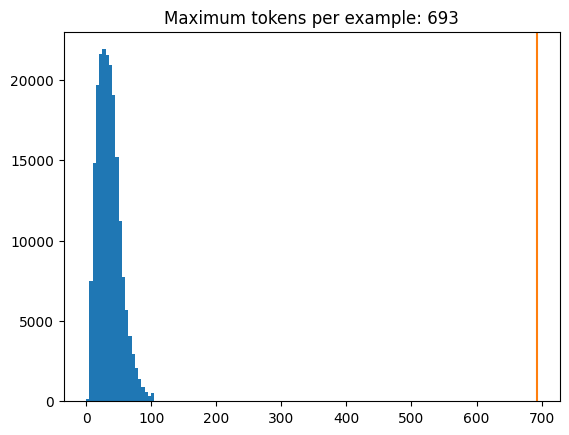

In [25]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

As you can see in the plot above, while the max value of tokens per example is quite large (in my version of the dataset I get 693) almost all of the samples are below just a bit more than 100 tokens. For this reason, we can safely cut our strings to 128 characters and pad shorter strings with zeroes so that all the input token lists have the same length.

In [28]:
MAX_TOKENS=128

def prepare_batch(fn, mt):
    fn = tokenizer.tokenize(fn)      # Output is ragged.
    fn = fn[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    fn = fn.to_tensor()  # Convert to 0-padded dense Tensor

    mt = tokenizer.tokenize(mt)
    mt = mt[:, :(MAX_TOKENS+1)]
    mt_inputs = mt[:, :-1].to_tensor()  # Drop the [END] tokens
    mt_labels = mt[:, 1:].to_tensor()   # Drop the [START] tokens

    return (fn, mt_inputs), mt_labels

---
`make_batches` uses the `prepare_batch` function defined above to provide ready to use batches from a dataset (note the data is shuffled again, which is probably not needed):

In [31]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def make_batches(ds):
    return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

train_batches = make_batches(train_ds)
val_batches = make_batches(val_ds)

# 5. Model definition

The following code has been taken as is from Tensorflow's tutorial on transformers. I removed pictures and tests to save space, but I'd suggest you to [check it out](https://www.tensorflow.org/text/tutorials/transformer) if you want to understand how this model works!

In [44]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

In [45]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [46]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

In [47]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [48]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [49]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [50]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

In [51]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [52]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

In [53]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
                   *,
                   d_model,
                   num_heads,
                   dff,
                   dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

In [54]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
                   dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                                 d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                         dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

In [55]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
                   input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        context, x  = inputs

        context = self.encoder(context)  # (batch_size, context_len, d_model)
        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

In [56]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [57]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=65535,
    target_vocab_size=65535,
    dropout_rate=dropout_rate)

In [59]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  11027328  
                                                                 
 decoder (Decoder)           multiple                  13138304  
                                                                 
 dense_16 (Dense)            multiple                  8454015   
                                                                 
Total params: 32,619,647
Trainable params: 32,619,647
Non-trainable params: 0
_________________________________________________________________


# 6. Define LR schedule, optimizer, and metrics

In [61]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [62]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [63]:
# plt.plot(learning_rate(tf.range(80000, dtype=tf.float32)))
# plt.ylabel('Learning Rate')
# plt.xlabel('Train Step')

In [64]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

# 7. Train model

Uncomment the `transformer.fit` cell below to train

In [65]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [239]:
# transformer.fit(train_batches,
#                 epochs=3,
#                 validation_data=val_batches)

Epoch 1/3


2023-01-28 00:01:41.661644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1497349 of 5879992
2023-01-28 00:01:51.661641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2993466 of 5879992
2023-01-28 00:02:01.661642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4489460 of 5879992
2023-01-28 00:02:10.943448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-01-28 00:02:10.943517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1 of 20000
2023-01-28 00:02:10.943552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2 of 20000
2023-01-28 00:02:10.943566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take 

82688/82688 [==============================] - ETA: 0s - loss: 0.6999 - masked_accuracy: 0.8064

2023-01-28 03:04:23.700289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1520983 of 5879992
2023-01-28 03:04:33.700287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3044188 of 5879992
2023-01-28 03:04:43.700287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4568413 of 5879992
2023-01-28 03:04:52.321352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-01-28 03:05:02.839160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1 of 20000
2023-01-28 03:05:02.839229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2 of 20000
2023-01-28 03:05:02.839244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take 

82688/82688 [==============================] - 11697s 141ms/step - loss: 0.6999 - masked_accuracy: 0.8064 - val_loss: 0.5099 - val_masked_accuracy: 0.8514
Epoch 2/3


2023-01-28 03:16:20.184706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1518701 of 5879992
2023-01-28 03:16:30.184699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3037721 of 5879992
2023-01-28 03:16:40.184696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4560204 of 5879992
2023-01-28 03:16:48.855674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-01-28 03:16:48.855738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1 of 20000
2023-01-28 03:16:48.855771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2 of 20000
2023-01-28 03:16:48.855784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take 

82688/82688 [==============================] - ETA: 0s - loss: 0.5279 - masked_accuracy: 0.8457

2023-01-28 06:18:32.447848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1562013 of 5879992
2023-01-28 06:18:42.447848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3019876 of 5879992
2023-01-28 06:18:52.447855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4451715 of 5879992
2023-01-28 06:19:02.447846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5795953 of 5879992
2023-01-28 06:19:03.222693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-01-28 06:19:14.552979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1 of 20000
2023-01-28 06:19:14.553046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this m

82688/82688 [==============================] - 11653s 140ms/step - loss: 0.5279 - masked_accuracy: 0.8457 - val_loss: 0.4587 - val_masked_accuracy: 0.8658
Epoch 3/3


2023-01-28 06:30:34.930874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1496686 of 5879992
2023-01-28 06:30:44.930873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2990353 of 5879992
2023-01-28 06:30:54.930875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4488804 of 5879992
2023-01-28 06:31:04.211045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-01-28 06:31:04.211115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1 of 20000
2023-01-28 06:31:04.211151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2 of 20000
2023-01-28 06:31:04.211165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take 

82688/82688 [==============================] - ETA: 0s - loss: 0.4972 - masked_accuracy: 0.8543

2023-01-28 09:33:04.211649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1515884 of 5879992
2023-01-28 09:33:14.211644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3028246 of 5879992
2023-01-28 09:33:24.211648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4545743 of 5879992
2023-01-28 09:33:33.002748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-01-28 09:33:43.644815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1 of 20000
2023-01-28 09:33:43.644881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2 of 20000
2023-01-28 09:33:43.644897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take 

82688/82688 [==============================] - 11666s 141ms/step - loss: 0.4972 - masked_accuracy: 0.8543 - val_loss: 0.4321 - val_masked_accuracy: 0.8734


# 8. Save/load model

The cells below are used to save (and optionally load a saved) model and then load it again (uncomment those you want to use)

In [67]:
# Use saved_model.save to save the whole model
# tf.saved_model.save(transformer, export_dir='transformer')

# Save the model weights only
# transformer.save_weights("trasformer_weights/epoch03.ckpt")

transformer.load_weights("./transformer_weights/epoch03.ckpt")

In [74]:
class Translator(tf.Module):
    def __init__(self, tokenizers, transformer):
        self.tokenizer = tokenizer
        self.transformer = transformer

    def __call__(self, sentence, max_length=MAX_TOKENS):

        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]

        sentence = self.tokenizer.tokenize(sentence).to_tensor()

        encoder_input = sentence

        start_end = self.tokenizer.tokenize(['\t\n'])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]

        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer([encoder_input, output], training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

            predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            output_array = output_array.write(i+1, predicted_id[0], tf.int32)

            if predicted_id == end:
                break

        output = tf.transpose(output_array.stack())
        # The output shape is `(1, tokens)`.
        text = tokenizer.detokenize(output)[0]  # Shape: `()`.

        tokens = tf.convert_to_tensor(list(text.numpy().decode("utf-8"))) #tokenizers.en.lookup(output)[0]

        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop.
        # So, recalculate them outside the loop.
        self.transformer([encoder_input, output[:,:-1]], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores

        return text, tokens, attention_weights
    

def print_translation(filename, predicted_movietitle, ground_truth):
    print(f'{"Input:":15s}: {filename}')
    print(f'{"Prediction":15s}: {predicted_movietitle.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [75]:
translator = Translator(tokenizer, transformer)

In [76]:
filename = 'Hellhole.2022.720p.WEBDL.English.Dubbed'
movietitle = 'Hellhole'

predicted_movietitle, predicted_tokens, attention_weights = translator(tf.constant(filename))
print_translation(filename, predicted_movietitle, movietitle)

Input:         : Hellhole.2022.720p.WEBDL.English.Dubbed
Prediction     : 	Hellhole

Ground truth   : Hellhole


In [127]:
for filenames, movietitles in test_ds.batch(10).take(1):
    for i in range(len(filenames)):
        filename = filenames[i]
        movietitle = movietitles[i]

        predicted_movietitle, predicted_tokens, attention_weights = translator(tf.constant(filename))
        print_translation(filename, predicted_movietitle, movietitle)        
        print("---")

2023-01-30 22:19:12.033181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3055120 of 5941106
2023-01-30 22:19:21.593444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


Input:         : b'\tMerlin - 03x12 - The coming of arthur.FOV\n'
Prediction     : 	Merlin The Coming of Arthur

Ground truth   : b'\tMerlin The Coming of Arthur: Part One\n'
---
Input:         : b'\t 30 Rock - Rockefeller Plaza 30 - Napisy PL Sezon 6 HDTV XviD S06E12\n'
Prediction     : 	30 Rock Napisy Planet of the Sun

Ground truth   : b"\t30 Rock St. Patrick's Day\n"
---
Input:         : b'\t Game.of.Silence.S01E09.WEB-DL.XviD-FUM[ettv]\n'
Prediction     : 	Game of Silence The Secret of Silence

Ground truth   : b'\tGame of Silence The Truth\n'
---
Input:         : b'\t Six.Feet.Under.S04E01.DVDRiP.x264-DBO\n'
Prediction     : 	Six Feet Under The Secret of the Sin

Ground truth   : b'\tSix Feet Under Falling into Place\n'
---
Input:         : b'\t720p.BluRay.x264-SPARKS (COLOR Hearing Impaired)\n'
Prediction     : 	The Strangers

Ground truth   : b'\tA Million Ways to Die in the West\n'
---
Input:         : b'\tBetter.Call.Saul.S04E01.Smoke.720p.NF.WEBRip.DDP5.1.x264-NTb\n'
Predict

# Show attention weights

In [94]:
sentence = '\t Elite.S02E03.36.hours.missing.720p.NF.WEB DL.DDP5.1.x264 MZABI\n'
ground_truth = "\tElite 36 horas desaparecido\n"

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : 	 Elite.S02E03.36.hours.missing.720p.NF.WEB DL.DDP5.1.x264 MZABI

Prediction     : 	Elite 36 horas desaparecido

Ground truth   : 	Elite 36 horas desaparecido



In [95]:
def plot_attention_head(in_tokens, translated_tokens, attention):
    # The model didn't generate `<START>` in the output. Skip it.
    translated_tokens = translated_tokens[1:]

    ax = plt.gca()
    # ax.figure.set_size_inches(10, 10)
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))

    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(
      labels) #, rotation=90)

    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)


In [96]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([28, 65])

In [97]:
in_tokens = tf.convert_to_tensor(list(sentence))
in_tokens

<tf.Tensor: shape=(65,), dtype=string, numpy=
array([b'\t', b' ', b'E', b'l', b'i', b't', b'e', b'.', b'S', b'0', b'2',
       b'E', b'0', b'3', b'.', b'3', b'6', b'.', b'h', b'o', b'u', b'r',
       b's', b'.', b'm', b'i', b's', b's', b'i', b'n', b'g', b'.', b'7',
       b'2', b'0', b'p', b'.', b'N', b'F', b'.', b'W', b'E', b'B', b' ',
       b'D', b'L', b'.', b'D', b'D', b'P', b'5', b'.', b'1', b'.', b'x',
       b'2', b'6', b'4', b' ', b'M', b'Z', b'A', b'B', b'I', b'\n'],
      dtype=object)>

In [98]:
translated_tokens

<tf.Tensor: shape=(29,), dtype=string, numpy=
array([b'\t', b'E', b'l', b'i', b't', b'e', b' ', b'3', b'6', b' ', b'h',
       b'o', b'r', b'a', b's', b' ', b'd', b'e', b's', b'a', b'p', b'a',
       b'r', b'e', b'c', b'i', b'd', b'o', b'\n'], dtype=object)>

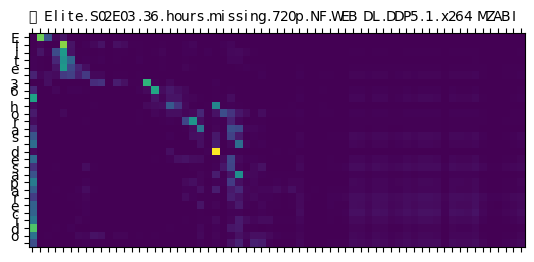

In [99]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [120]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
    in_tokens = tf.convert_to_tensor(list(sentence))
    
    fig = plt.figure(figsize=(10, 10))

    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(4, 2, h+1)
        plot_attention_head(in_tokens, translated_tokens, head)
        ax.set_xlabel(f'Head {h+1}')

    plt.tight_layout()
    plt.show()

/var/folders/3w/1spf9bkn2gjbc8026chntkb80000gn/T/ipykernel_56483/1771425617.py:11: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()


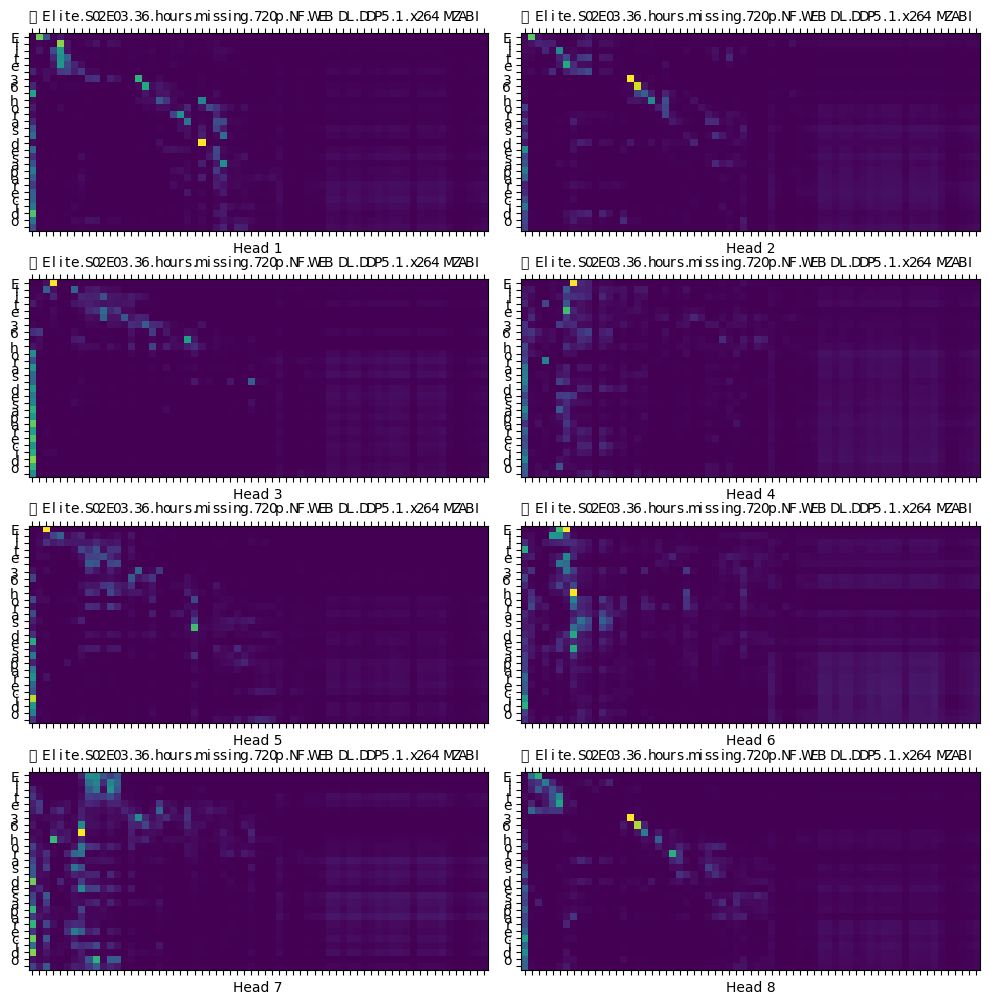

In [121]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

In [122]:
class ExportTranslator(tf.Module):
    def __init__(self, translator):
        self.translator = translator

    # @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def __call__(self, sentence):
        (result,
         tokens,
         attention_weights) = self.translator(tf.constant(sentence), max_length=MAX_TOKENS)

        return result

In [123]:
my_translator = ExportTranslator(translator)

In [126]:
my_translator(b'\tBig.Mouth.2022.1080p.DSNP.WEB-DL.AAC2.0.H.264-ECLiPSE\n').numpy()

b'\tBig Mouth\n'

In [393]:
### A couple of ways to save the translator model

# 1) use tf.saved_model
# tf.saved_model.save(my_translator, export_dir='my_translator')

# 2) use model.save
##   NOTE: This one breaks due to custom LR schedule
##   TODO: fix by defining config as
##   def get_config(self):
##      config = {
##      'd_model': self.d_model,
##      'warmup_steps': self.warmup_steps,
##
##       }
##      return config

# !mkdir -p "saved_model"
# transformer.save("saved_model/epoch03")